In [221]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [222]:
!pip install lightGBM

In [223]:
import gc
gc.collect()

19173

In [224]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
is_denso = True
train_path = '/home/hayato/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
if is_denso:
    train_path = '/home/denso/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
train_data = pd.read_csv(train_path, encoding='utf-8')
train_data_for_ranking = train_data.copy()
print("train data length {}".format(len(train_data)))

train data length 741498


In [225]:
from pathlib import Path
import pandas as pd
import tqdm
def read_csv_data(train_path):
    # csvデータを読み込み、1行にまとめる
    p = Path(train_path)
    files = list(p.glob("inference*.csv"))
    df = pd.DataFrame()
    for i, file in tqdm.tqdm(enumerate(files)):
        race_csv_data = pd.read_csv(file, encoding='utf-8')
        # 各CSVファイルのデータを1行にまとめる
        race_csv_data = race_csv_data.sum(axis=0).to_frame().T
        
        # データフレームに追加
        df = pd.concat([df, race_csv_data], ignore_index=True)
    return df

inference_data = "/home/hayato/keiba_analysis/inference/2024070402/"
if is_denso:
    inference_data = "/home/denso/keiba_analysis/inference/2024070402/"
inference_data = read_csv_data(inference_data)
inference_data

0it [00:00, ?it/s]


""


In [226]:
train_data


,Unnamed: 0,target_no1_umaban,date,race_name,place,class_list_in_race,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds,goal_number
0,0,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",シゲルダイノウカイ,1,2,0,462,4,54.0,小原義之,7.0,2
1,1,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スイートゴールド,2,2,1,-14,-14,53.0,藤岡佑介,81.6,10
2,2,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",スズカイエロー,3,2,0,500,-2,54.0,蛯名正義,2.3,6
3,3,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",インザリピート,4,2,1,448,-8,54.0,松永幹夫,74.4,8
4,4,5,2005081300,2歳未勝利,",1回札幌1日目",",2歳未勝利",10,1500,",芝",テイエムヒスイ,5,2,1,432,-18,54.0,秋山真一,3.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741493,741493,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",トロハ,12,3,1,468,2,52.0,武豊,17.5,15
741494,741494,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",サダムラピュタ,13,4,0,486,12,57.0,秋山真一,7.7,5
741495,741495,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",バイマイサイド,14,4,0,484,18,57.0,浜中俊,4.4,1
741496,741496,14,2019090100,3歳以上1勝クラス,",2回小倉12日目",",3歳以上1勝クラス",16,2600,",芝",シエラネバダ,15,4,0,504,-2,57.0,松山弘平,21.9,3


In [227]:
train_data.describe()

,Unnamed: 0,target_no1_umaban,date,number_of_horses,distance,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,odds,goal_number
count,741498.000000,741498.00000,7.414980e+05,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000
mean,370748.500000,7.87469,2.012057e+09,14.783031,1642.615530,7.891516,3.656019,0.449531,469.330962,0.254822,55.058424,67.459365,7.891516
std,214052.179289,4.44242,4.293032e+06,2.302275,432.645537,4.460383,1.349710,0.563194,36.993146,6.557119,1.782221,96.571090,4.460383
min,0.000000,1.00000,2.005010e+09,4.000000,1000.000000,1.000000,2.000000,0.000000,-26.000000,-54.000000,47.000000,1.000000,1.000000
25%,185374.250000,4.00000,2.008101e+09,14.000000,1200.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,8.700000,4.000000
50%,370748.500000,8.00000,2.012062e+09,16.000000,1600.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,25.900000,8.000000
75%,556122.750000,11.00000,2.016031e+09,16.000000,1800.000000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,84.200000,11.000000
max,741497.000000,18.00000,2.019123e+09,18.000000,4260.000000,18.000000,13.000000,2.000000,640.000000,60.000000,66.000000,999.900000,18.000000


In [228]:
# 前処理
def preprocess(train_data, is_ranking=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    train_data = train_data.drop(['Unnamed: 0','target_no1_umaban', 'class_list_in_race'], axis=1)
    # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない
    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        train_data['goal_number'] = train_data['goal_number'].replace([1], 0)
        train_data['goal_number'] = train_data['goal_number'].replace([2,3], 1)
        train_data['goal_number'] = train_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 2)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        train_data['goal_number_replace'] = train_data['goal_number'].replace([1], 30)
        train_data['goal_number_replace'] = train_data['goal_number'].replace([2], 28)
        train_data['goal_number_replace'] = train_data['goal_number'].replace([3], 26)
        train_data['goal_number_replace'] = train_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    train_data.columns = train_data.columns.str.replace(":", "_")
    train_data.columns = train_data.columns.str.replace(",", "_")
    train_data.columns = train_data.columns.str.replace("'", "_")
    train_data.columns = train_data.columns.str.replace('"', "_")
    train_data.columns = train_data.columns.str.replace(" ", "_")
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    if not is_ranking:
        train_data = train_data[30000:]
    return train_data

train_data = preprocess(train_data)

In [229]:
# inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
# object型の特長量を確認する
object_columns = inference_data.select_dtypes(include='object').columns
object_columns
for column in object_columns:
    le = LabelEncoder()
    inference_data[column] = le.fit_transform(inference_data[column])

In [230]:
# train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

In [231]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [232]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [233]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [234]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 398438
valid data length 99610
test data length 213450
train data length 398438
valid data length 99610
test data length 213450


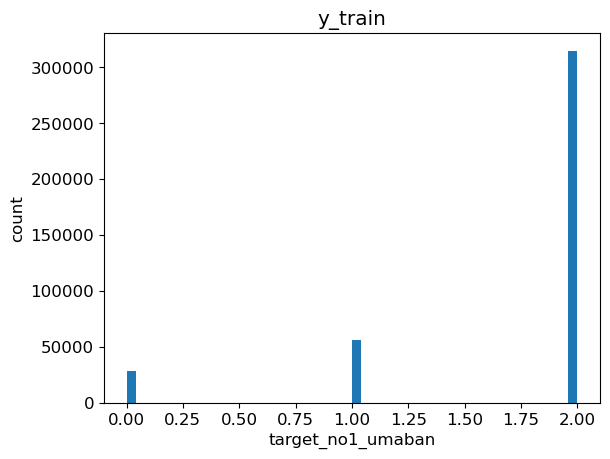

77076     0
731534    2
726246    2
333464    2
253761    2
         ..
203527    2
599382    1
565983    2
92360     2
110783    2
Name: goal_number, Length: 398438, dtype: int64


In [235]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [236]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[4.7707415  0.42167705 0.42167705 ... 0.42167705 0.42167705 0.42167705]
[1. 1. 1. ... 1. 1. 1.]


In [237]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [238]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [239]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 398438, number of used features: 15
[LightGBM] [Info] Start training from score -2.661114
[LightGBM] [Info] Start training from score -1.968721
[LightGBM] [Info] Start training from score -0.235097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	train's multi_logloss: 0.522459	valid's multi_logloss: 0.525926


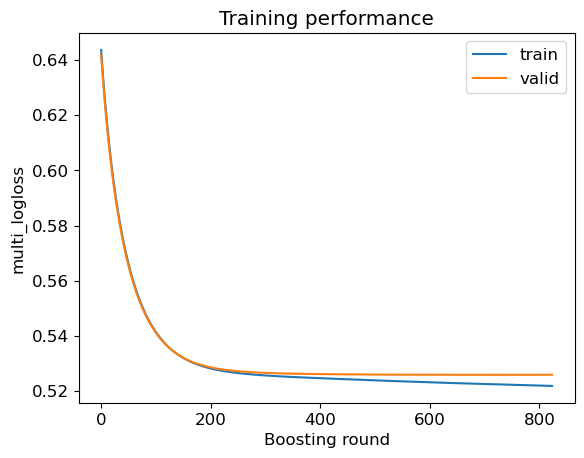

In [240]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [241]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.009234  0.048164  0.942602
1  0.081835  0.244974  0.673191
2  0.234929  0.345968  0.419102
3  0.047664  0.140822  0.811514
4  0.068221  0.222638  0.709141
0        0.009234
1        0.081835
2        0.234929
3        0.047664
4        0.068221
           ...   
99605    0.019574
99606    0.005302
99607    0.009510
99608    0.006204
99609    0.006400
Name: 0, Length: 99610, dtype: float64


In [242]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        2
1        2
2        2
3        2
4        2
        ..
99605    2
99606    2
99607    2
99608    2
99609    2
Length: 99610, dtype: int64

In [243]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

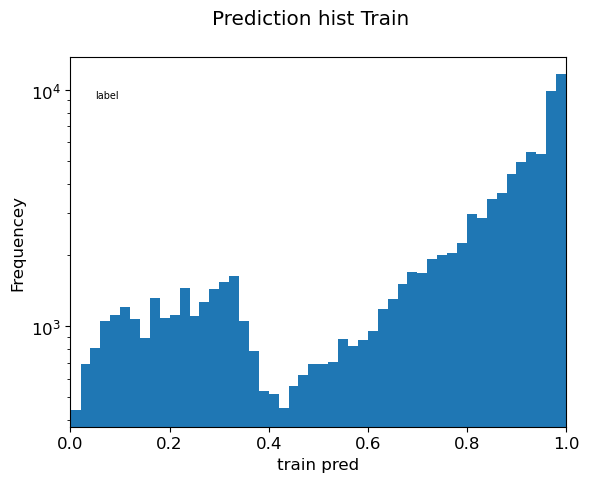

In [244]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [245]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

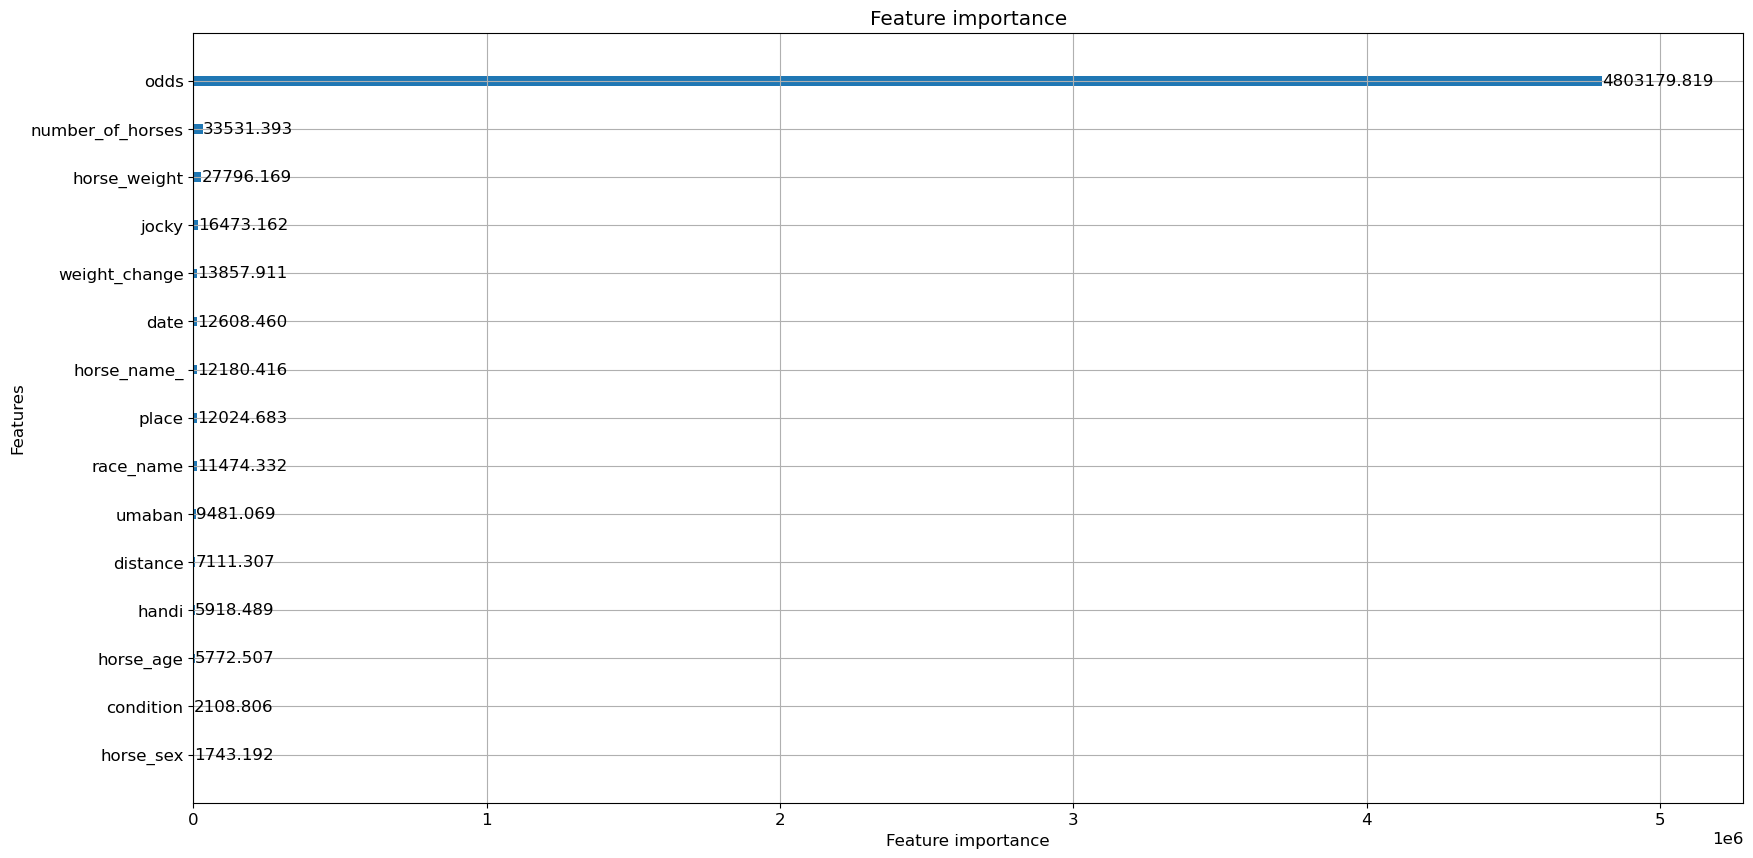

In [246]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7969782150386507


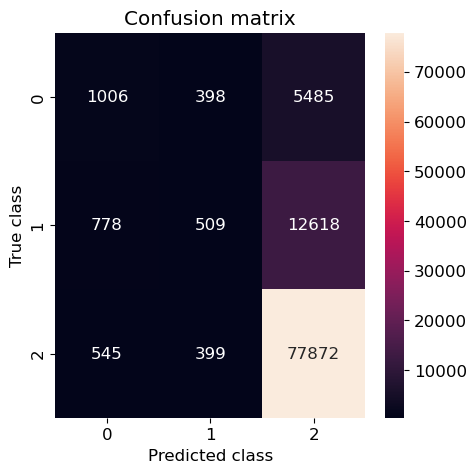

In [247]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7969782150386507


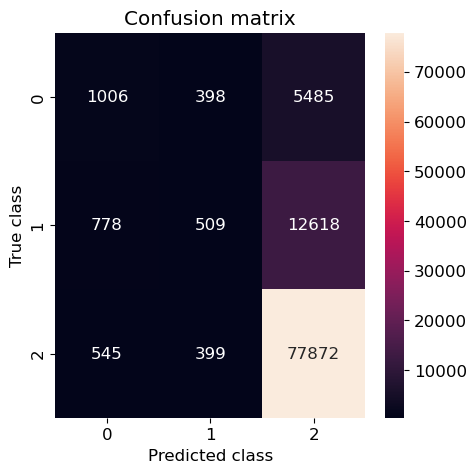

In [248]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.44      0.14      0.21     14865
           1       0.39      0.04      0.07     29646
           2       0.81      0.99      0.89    168939

    accuracy                           0.80    213450
   macro avg       0.55      0.39      0.39    213450
weighted avg       0.73      0.80      0.73    213450



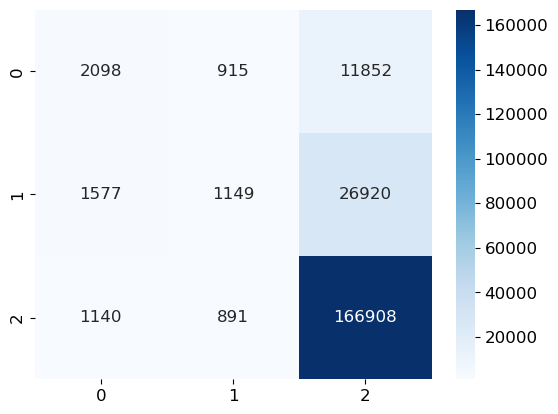

In [249]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [250]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())

    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    print(df[['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]].drop_duplicates().head())

    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    sorted_df = df.set_index(['date', 'race_name', 'place', 'number_of_horses', 'distance',"target_no1_umaban"]).sort_index(level='date', ascending=True).reset_index()

    # ソートデータの保存
    sorted_df.to_csv("sorted_{}_data.csv".format(name), index=False)
    return horse_counts_list, sorted_df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Unique combinations of date, race_name, place, number_of_horses, distance:
          date race_name     place  number_of_horses  distance  \
0   2005081300     2歳未勝利  ,1回札幌1日目                10      1500   
10  2005081300     3歳未勝利  ,1回札幌1日目                12      1000   
22  2005081300     3歳未勝利  ,1回札幌1日目                13      1700   
35  2005081300      2歳新馬  ,1回札幌1日目                13      1200   
48  2005081300     3歳未勝利  ,1回札幌1日目                16      2000   

    target_no1_umaban  
0                   5  
10                  4  
22                 13  
35                  3  
48                 12  

Resulting list of horse counts per race (sorted by date):
[8, 7, 15, 13, 10, 16, 16, 16, 16, 16, 16, 11, 12, 15, 16, 16, 16, 16, 13, 16, 14, 11, 16, 15, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 14, 9, 13, 16, 15, 16, 16, 14, 15, 15, 15, 16, 16, 16, 15, 16, 16, 13, 14, 16, 16, 16, 15, 16, 10, 11, 16, 16, 12, 16, 14, 14, 16, 12, 16, 16, 16, 16, 13, 16, 16

In [251]:
# クエリの数の合計とデータ数が一致しているか確認
print("Number of queries in train data: {}".format(len(train_query)))
print("Number of queries in valid data: {}".format(len(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 25256
Number of queries in valid data: 7525
Total number of queries: 32781
Number of rows in train data: 363333
Number of rows in valid data: 109000
Total number of rows: 472333


In [252]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

In [254]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [255]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363333 entries, 0 to 363332
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              363333 non-null  int64  
 1   race_name         363333 non-null  int64  
 2   place             363333 non-null  int64  
 3   number_of_horses  363333 non-null  int64  
 4   distance          363333 non-null  int64  
 5   condition         363333 non-null  int64  
 6   horse_name_       363333 non-null  int64  
 7   umaban            363333 non-null  int64  
 8   horse_age         363333 non-null  int64  
 9   horse_sex         363333 non-null  int64  
 10  horse_weight      363333 non-null  int64  
 11  weight_change     363333 non-null  int64  
 12  handi             363333 non-null  float64
 13  jocky             363333 non-null  int64  
 14  odds              363333 non-null  float64
dtypes: float64(2), int64(13)
memory usage: 41.6 MB


In [256]:
# 検証データ
X_sorted_valid_data.describe()

,date,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,1.090000e+05,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000,109000.000000
mean,2.010833e+09,207.024202,170.579248,14.870450,1641.745413,0.548670,9023.101541,7.935376,3.654248,0.436385,468.772028,0.287284,55.106986,152.301183,72.548070
std,7.053832e+05,377.070403,99.675925,2.252645,435.806863,0.561454,5197.472495,4.476170,1.329049,0.548820,37.141242,6.615407,1.755447,72.192393,104.475815
min,2.010010e+09,0.000000,0.000000,5.000000,1000.000000,0.000000,0.000000,1.000000,2.000000,0.000000,-18.000000,-54.000000,48.000000,0.000000,1.100000
25%,2.010082e+09,9.000000,82.000000,14.000000,1200.000000,0.000000,4506.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,91.000000,8.700000
50%,2.011041e+09,11.000000,169.000000,16.000000,1600.000000,1.000000,9077.500000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,150.000000,26.400000
75%,2.011102e+09,186.000000,251.000000,16.000000,1800.000000,1.000000,13503.000000,12.000000,4.000000,1.000000,490.000000,4.000000,56.000000,208.000000,91.700000
max,2.012112e+09,1295.000000,354.000000,18.000000,4260.000000,2.000000,17994.000000,18.000000,11.000000,2.000000,620.000000,48.000000,65.000000,295.000000,999.900000


In [257]:
# 学習データの答え
print(y_train_ranking.head())
y_train_ranking.describe()

0    30
1    26
2     0
3     0
4     0
Name: goal_number, dtype: int64


count    363333.000000
mean          5.857503
std          11.413061
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: goal_number, dtype: float64

In [258]:
# 検証データの答え
print(y_valid_ranking.head())
y_valid_ranking.describe()

0     0
1     0
2     0
3     0
4    28
Name: goal_number, dtype: int64


count    109000.000000
mean          5.815009
std          11.382484
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: goal_number, dtype: float64

In [259]:
# テストデータ
test_ranking.describe()

,date,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,2.224500e+05,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000,222450.000000
mean,2.017244e+09,235.144967,147.440899,14.690276,1649.471477,0.537510,14522.473630,7.845246,3.636372,0.479820,469.636723,0.303021,54.968739,160.427318,65.922575
std,1.324075e+06,451.011241,83.903436,2.409721,423.376533,0.558833,8386.199383,4.453813,1.365377,0.577414,36.681482,6.377300,1.792766,70.308268,94.443572
min,2.015010e+09,0.000000,0.000000,5.000000,1000.000000,0.000000,0.000000,1.000000,2.000000,0.000000,-22.000000,-48.000000,47.000000,0.000000,1.100000
25%,2.016072e+09,13.000000,75.000000,13.000000,1400.000000,0.000000,7292.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,98.000000,8.400000
50%,2.017090e+09,15.000000,151.000000,16.000000,1600.000000,1.000000,14380.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,161.000000,25.200000
75%,2.018103e+09,176.000000,219.000000,16.000000,1800.000000,1.000000,21857.000000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,213.000000,81.200000
max,2.019123e+09,1602.000000,291.000000,18.000000,4250.000000,2.000000,29015.000000,18.000000,12.000000,2.000000,640.000000,48.000000,64.000000,284.000000,999.900000


In [260]:
# テストデータの答え
print(y_test_true_ranking.head())
y_test_true_ranking.describe()

519048     0
519049    28
519050     0
519051     0
519052     0
Name: goal_number, dtype: int64


count    222450.000000
mean          5.921852
std          11.458974
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: goal_number, dtype: float64

In [261]:
# ranking trainning
model = lgb.LGBMRanker(
    random_state=42,
    n_estimators=10000,
    learning_rate=0.01,
    num_leaves=15,
    max_depth=12,
    min_data_in_leaf=10,
    objective='lambdarank',
    metric='ndcg',
    min_child_samples=50,
)

model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 3, 5],
    eval_metric='ndcg',
)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 363333, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10


LGBMRanker(learning_rate=0.01, max_depth=12, metric='ndcg',
           min_child_samples=50, min_data_in_leaf=10, n_estimators=10000,
           num_leaves=15, objective='lambdarank', random_state=42)

In [ ]:
#　テストデータで推論

prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア": prediction_test_ranking,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
})
print(df_prediction_test_ranking)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
        馬番号     予測スコア  着順関連度
519048   13 -2.312482      0
519049   14  0.129040     28
519050   15 -2.200362      0
519051   16 -3.174111      0
519052    1 -0.828379      0
...     ...       ...    ...
741493   12 -0.881115      0
741494   13  0.470048      0
741495   14  0.570163     30
741496   15 -1.034509     26
741497   16 -0.680046      0

[222450 rows x 3 columns]


In [263]:
# モデルの評価
# クエリごとにNDCGを計算し、その平均値を算出
# NDCGの計算
ndcg_score = df_prediction_test_ranking.groupby("馬番号").apply(lambda x: metrics.ndcg_score([x["着順関連度"]], [x["予測スコア"]], k=3))
print(ndcg_score)

In [264]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

             columns  importance
14              odds       20538
6        horse_name_       15264
0               date       14377
2              place       14304
13             jocky       13728
10      horse_weight       13647
11     weight_change        9108
7             umaban        8769
1          race_name        8632
4           distance        6194
3   number_of_horses        5352
12             handi        4620
8          horse_age        2877
9          horse_sex        1551
5          condition        1039


In [265]:
############ real inference ############
print("real inference")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(inference_data)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)
print(y_pred.head())
print(y_pred[0])
print(y_pred_submit)


real inference


ValueError: Input data must be 2 dimensional and non empty.